In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def l1_regularization_activations(h, lambda_l1):
    l1_norm = torch.sum(h.abs())
    return lambda_l1 * l1_norm
 # write a function to convert a number to one-hot vector, e.g. 3 -> [0, 0, 0, 1, 0, 0, 0]
    # x is a vector of numbers, n is the length of the one-hot vector
    
def to_onehot(x, n):
    x_onehot = np.zeros((len(x), n), dtype=np.int64)
    for i in range(len(x)):
        x_onehot[i, x[i]] = 1
    return x_onehot

class Net(nn.Module):
        def __init__(self, n_neurons, n_layers, input_dim, output_dim):
            super(Net, self).__init__()
            self.embedding = nn.Linear(input_dim, input_dim)
            self.lstm = nn.LSTM(input_size=input_dim, hidden_size=n_neurons, num_layers=n_layers)
            self.fc = nn.Linear(n_neurons, output_dim, bias=True)

        def forward(self, x, h_prev, c_prev):
            x = x.detach().clone()
            x = (x - x.mean())/x.std()
            x = self.embedding(x)
            _, (h, c) = self.lstm(x, (h_prev, c_prev))
            h = F.relu(h)
            out = self.fc(h)
            return out, (h, c)

# task structure      
trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,6,1,1,1,5,5,1,1,0])
trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,6,1,1,0])


# fix the random seeds for reproducibility
random_seeds = np.arange(2100,2110)

loss_curve_all = []
corr_curve_all = []
accuracy_curve_all = []
accuracy_curve_all_test = []

num_trials = 200
n_neurons = 128
n_batchs = 1
tr_len = len(trial1x)


for run in range(10):
    print(f'run {run}')
    torch.manual_seed(random_seeds[run])
    np.random.seed(random_seeds[run])
    
    trials = np.random.choice(2, num_trials-2)
    trials = np.concatenate((trials, np.array([0, 1])))
    x = np.zeros(num_trials*tr_len, dtype=np.int64)

    for trial in range(len(trials)):
        if trials[trial] == 0:
            x[trial*tr_len: (trial+1)*tr_len] = trial1x
        else:
            x[trial*tr_len: (trial+1)*tr_len] = trial2x

    OBS = len(np.unique(x))

    x = to_onehot(x, 8)
    
    #train test split
    train_x = torch.tensor(x[:2300], dtype=torch.float32)
    test_x  = torch.tensor(x[2300:], dtype=torch.float32)


    model = Net(n_neurons=n_neurons, n_layers=1, input_dim=8, output_dim=8)

    loss_func = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)

    optimizer = optim.Adam(model.parameters(), lr=5e-5)


    loss_curve = []
    accuracy_curve = []
    accuracy_curve_test = [] 
    corr_curve = []


    for epoch in range(20):
        
        h0 = torch.randn(1, n_batchs, n_neurons)
        c0 = torch.randn(1, n_batchs, n_neurons)

        reward_error = 0
        reward_count = 0
        for i in range(1,2298):
            if i == 1:
                h_prev = h0
                c_prev = c0

            loss = 0

            optimizer.zero_grad()
            input_x = (train_x[i]).view(1, 1, -1)

            prediction, (h, c) = model(input_x, h_prev=h_prev, c_prev=c_prev)
            h_prev = h.detach()
            c_prev = c.detach()

            beta = 1
            
            if train_x[i+1].argmax().item() == 6 or train_x[i+1].argmax().item() == 7:
                reward_count += 1
                if abs(train_x[i+1].argmax().item() - prediction[0].argmax().item()) > 0.5:
                    reward_error += 1

            base_loss = beta * loss_func(prediction[0], train_x[i+1].argmax().view(1)) 
            l1_loss = l1_regularization_activations(h, lambda_l1=0)  # tune lambda_l1 to adjust the level of sparsity
            loss = base_loss + l1_loss

            loss.backward()
            optimizer.step()


        loss_curve.append(loss.item())
        accuracy_curve.append(1 - reward_error/reward_count)
        
        print('\r', epoch, loss.item(), reward_error, reward_count)

        model.eval()

        # test the model using test_x
        h0 = torch.zeros(1, n_batchs, n_neurons)
        c0 = torch.zeros(1, n_batchs, n_neurons)

        test_y = torch.zeros(2300, 8)
        test_h = torch.zeros(2300, n_neurons)
        
        reward_error_test = 0   
        reward_count_test = 0   

        with torch.no_grad():
            for i in range(1, 2299):
                if i == 1:
                    h_prev = h0
                    c_prev = c0

                input_x_test = (test_x[i]).view(1, 1, -1)
                prediction, (h, c) = model(input_x_test, h_prev=h_prev, c_prev=c_prev)
                h_prev=h.detach()
                c_prev=c.detach()
                test_y[i] = prediction.detach()
                test_h[i] = h.detach()
                if test_x[i+1].argmax().item() == 6 or test_x[i+1].argmax().item() == 7:
                    reward_count_test += 1
                    if abs(test_x[i+1].argmax().item() - prediction[0].argmax().item()) > 0.5:
                        reward_error_test += 1

            # Add test set accuracy for current epoch
            accuracy_curve_test.append(1 - reward_error_test / reward_count_test)
            print(f'TEST: reward error {reward_error_test} reward count {reward_count_test}')


            # plot correlation matrix every epoch
            a = np.arange(0, 2300, 23)
            b = a + 23

            test_trials = trials[100:]

            ind0 = np.where(test_trials == 0)
            ind1 = np.where(test_trials == 1)

            total0 = []
            for i in ind0[0][:]:
                total0.append(test_h[a[i]:b[i], :].squeeze().detach().numpy())

            total1 = []
            for i in ind1[0][:]:
                total1.append(test_h[a[i]:b[i], :].squeeze().detach().numpy())


            mean0 = np.array(total0).mean(0)
            mean1 = np.array(total1).mean(0)

            plt.figure(figsize=(6,5))
            sns.heatmap(np.corrcoef(mean0,mean1)[:23, 23:], cmap='icefire',vmin = -1,vmax = 1);
            plt.show()
            
            corr_curve.append(np.corrcoef(mean0,mean1)[:23, 23:])
     
        model.train()
        
    loss_curve_all.append(loss_curve)
    corr_curve_all.append(corr_curve)
    accuracy_curve_all.append(accuracy_curve)
    accuracy_curve_all_test.append(accuracy_curve_test)
    
    plt.figure(figsize=(6,5))
    plt.plot(loss_curve);
    plt.show()

np.save('NearFar_corr_all.npy', np.array(corr_curve_all))
np.save('loss_all.npy', np.array(loss_curve_all))      
np.save('accuracy_curve_all.npy', np.array(accuracy_curve_all))      
np.save('accuracy_curve_all_test.npy', np.array(accuracy_curve_all_test))      



## Plot LSTM reward region prediction test accuracy

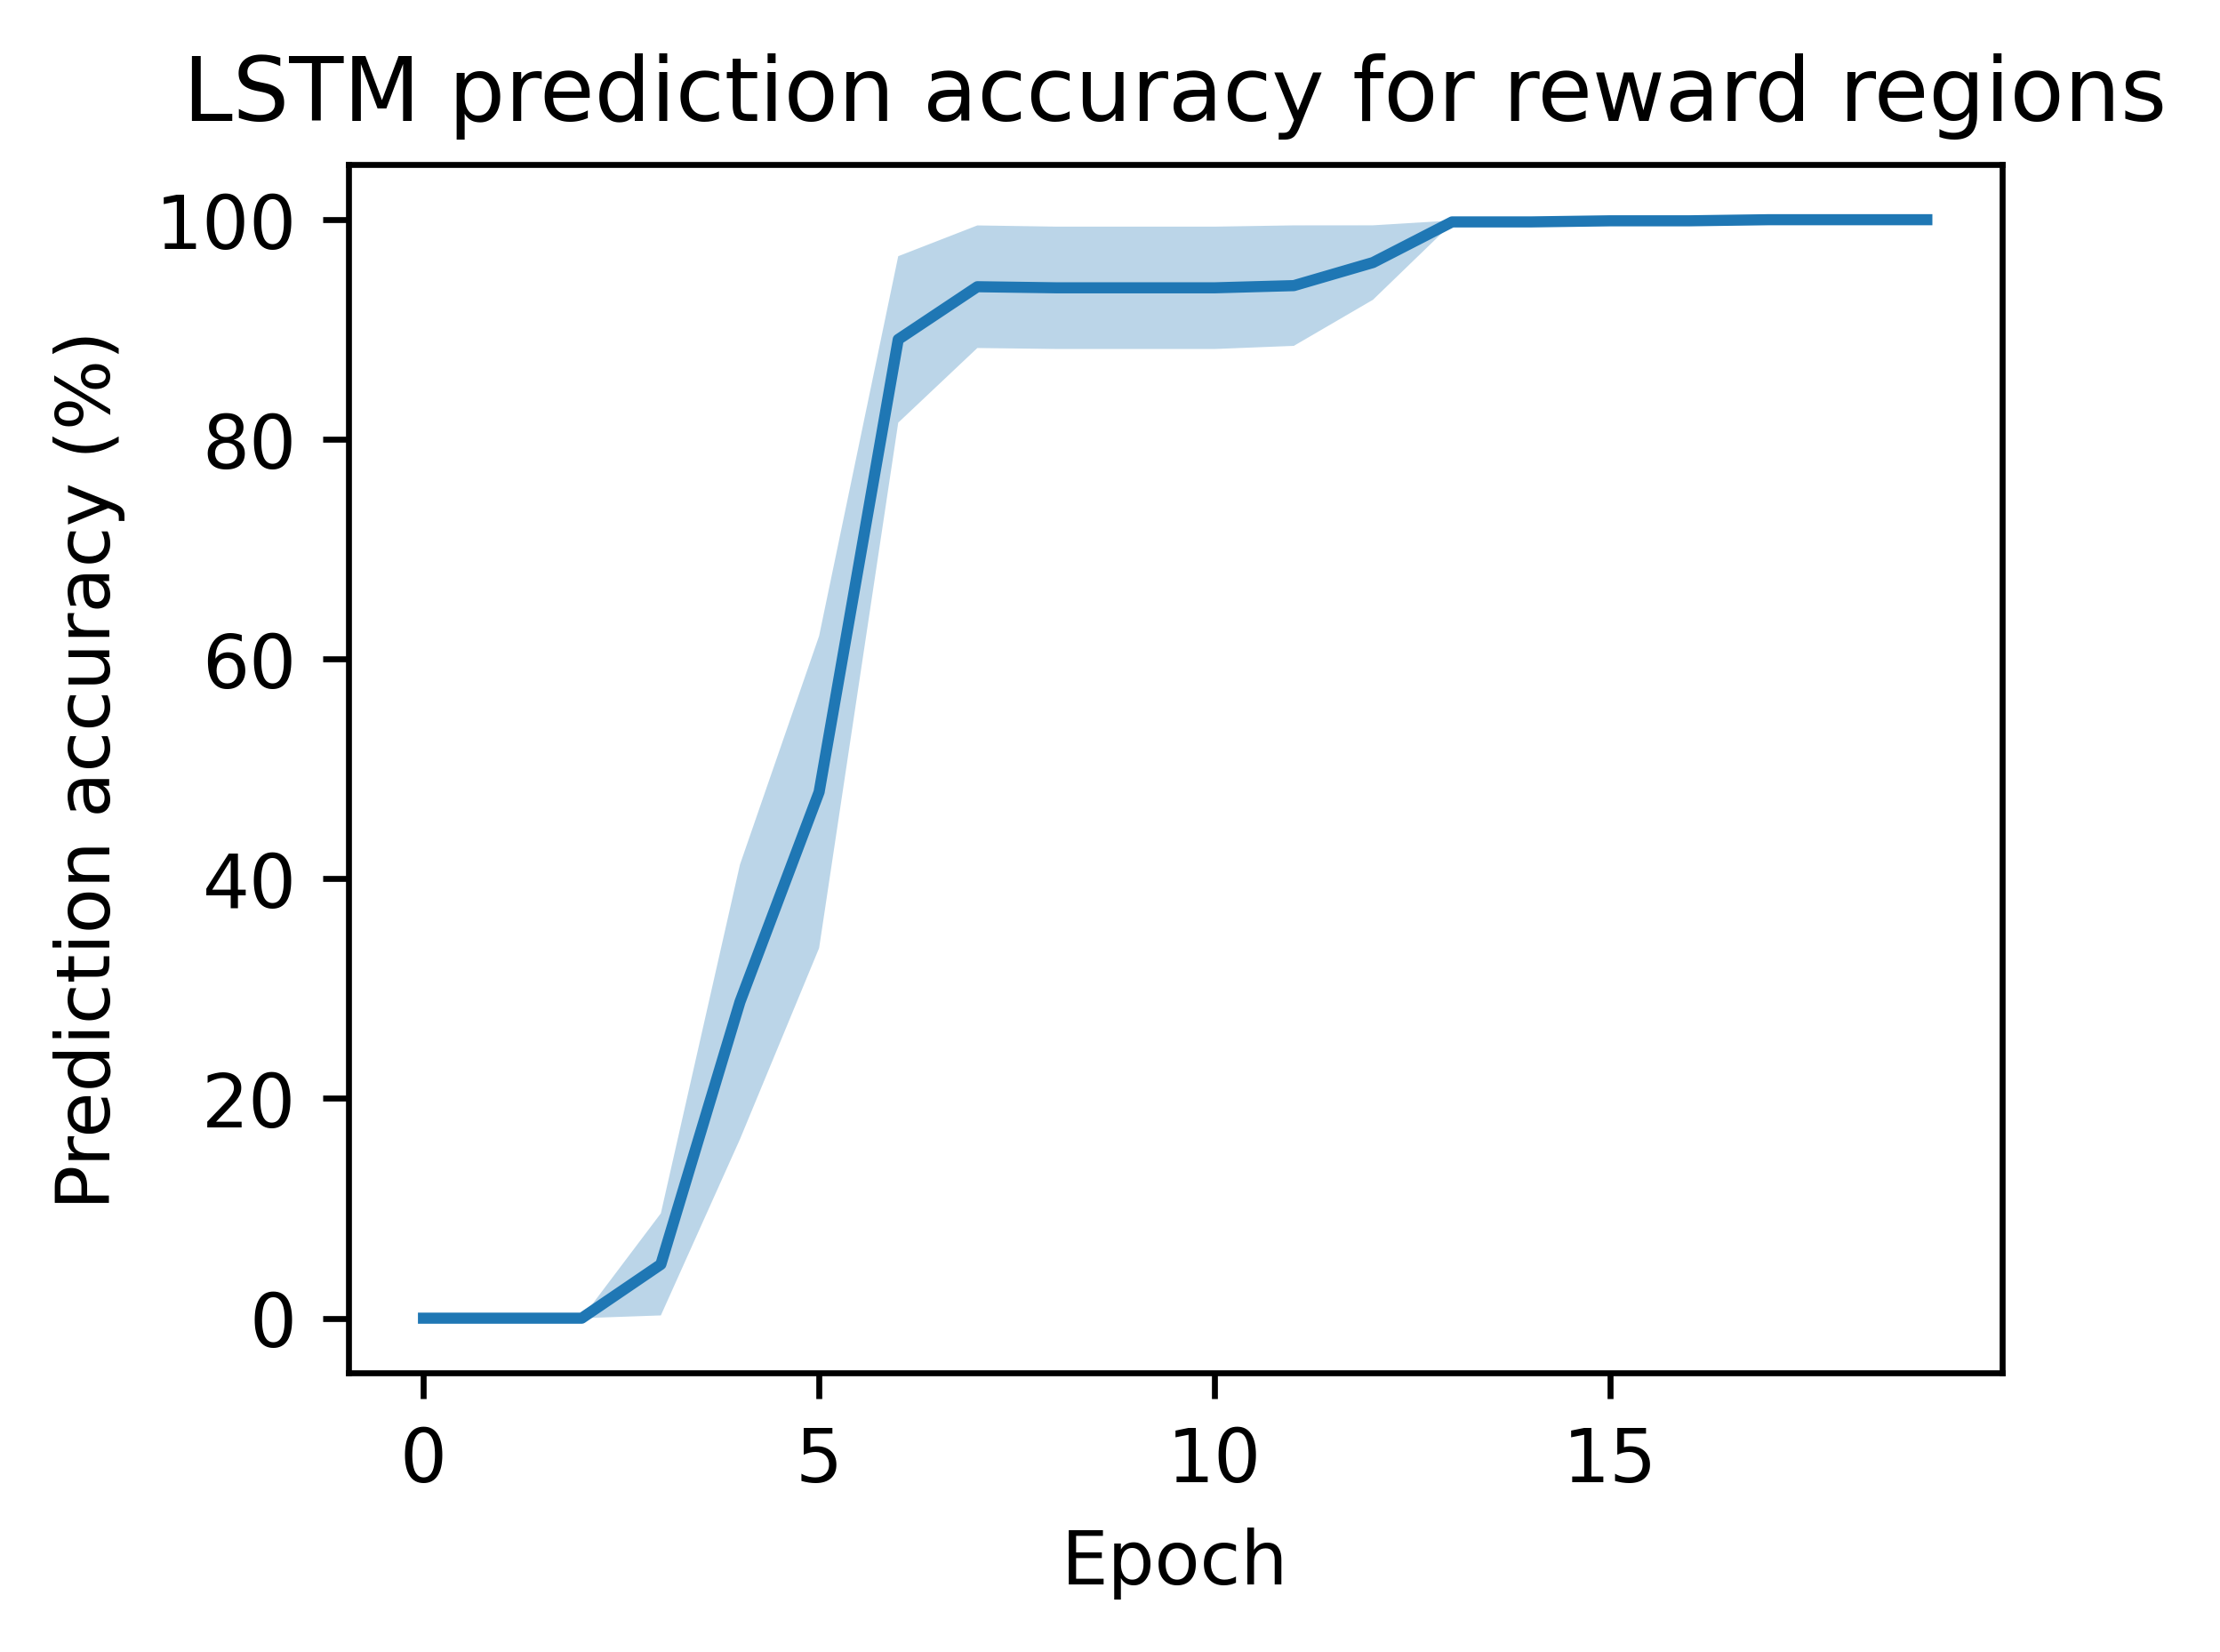

In [11]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

A = np.array(accuracy_curve_all_test)  * 100
# Compute the combined mean and standard error of the mean (SEM)
combined_mean = np.mean(A, axis=0)
combined_sem = np.std(A, axis=0) / np.sqrt(A.shape[0])

# Plotting
x = np.arange(A.shape[1])  # Time points

fig, ax = plt.subplots(figsize=(4, 3),dpi = 600)
ax.plot(x, combined_mean, label='Mean')
ax.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)

ax.set_xlabel('Epoch')
ax.set_ylabel('Prediction accuracy (%)')
ax.set_title('LSTM prediction accuracy for reward regions')
plt.savefig('LSTM_reward_test_accuracy.pdf', format='pdf', dpi=600)
plt.show()


## Plot loss

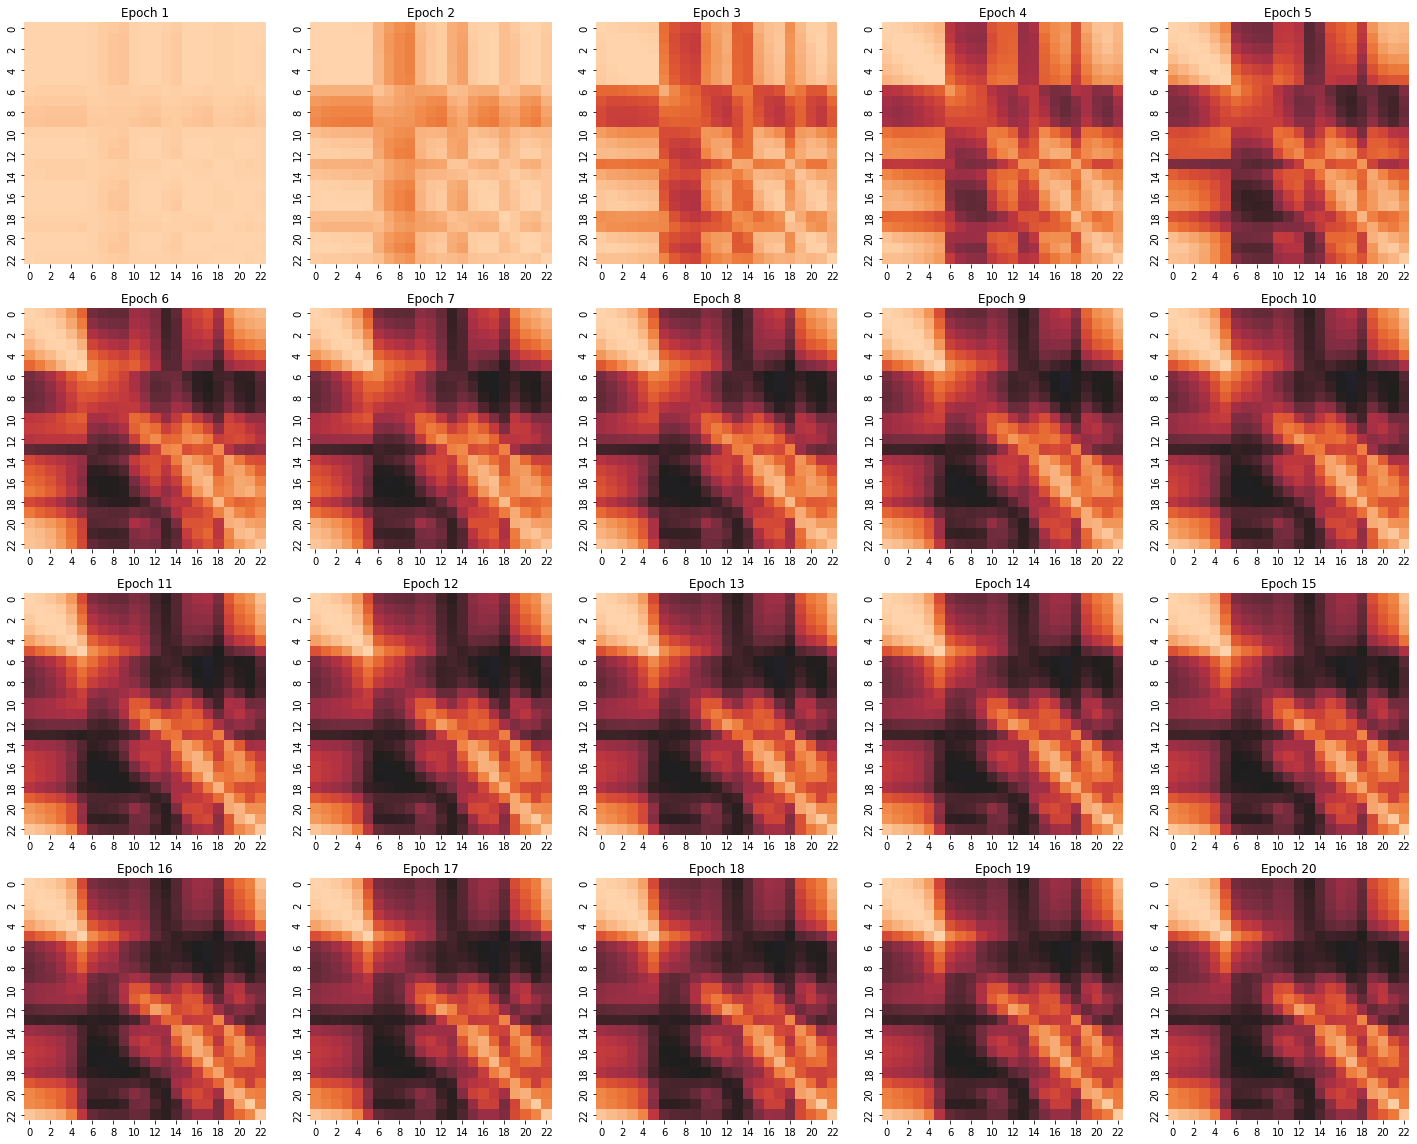

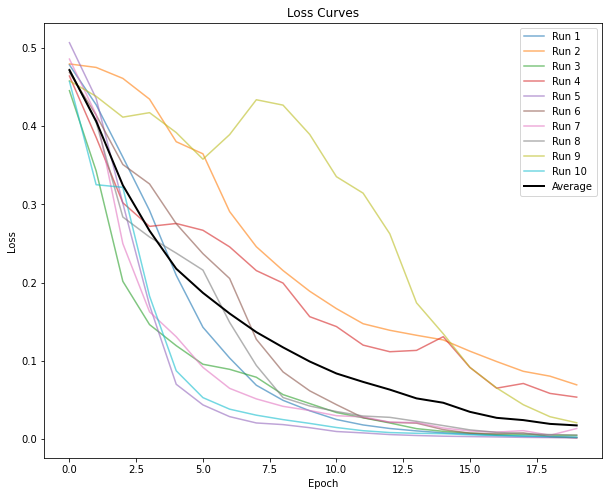

In [8]:
# # load the npy files
# corr_curve = np.load('NearFar_corr_all.npy')
# loss_all = np.load('loss_all.npy')
corr_curve = np.array(corr_curve_all)
# calculate the average correlation matrix
avg_corr = corr_curve.mean(axis=0)

# plot the average correlation matrices for each epoch in subplots
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

for i in range(4):
    for j in range(5):
        epoch = i*5 + j
        sns.heatmap(avg_corr[epoch], cmap='icefire', vmin=-1, vmax=1, ax=axs[i,j], cbar=False)  
        axs[i,j].set_title(f'Epoch {epoch+1}')
        axs[i,j].set_aspect('equal')  # add this line to make each subplot square

plt.tight_layout()
plt.show()

# plot the loss curves for each run
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(loss_all[i], label=f'Run {i+1}', alpha=0.6)

# calculate the average loss curve
avg_loss = loss_all.mean(axis=0)

# plot the average loss curve
plt.plot(avg_loss, label='Average', linewidth=2, color='black')

plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Plot correlation matrices

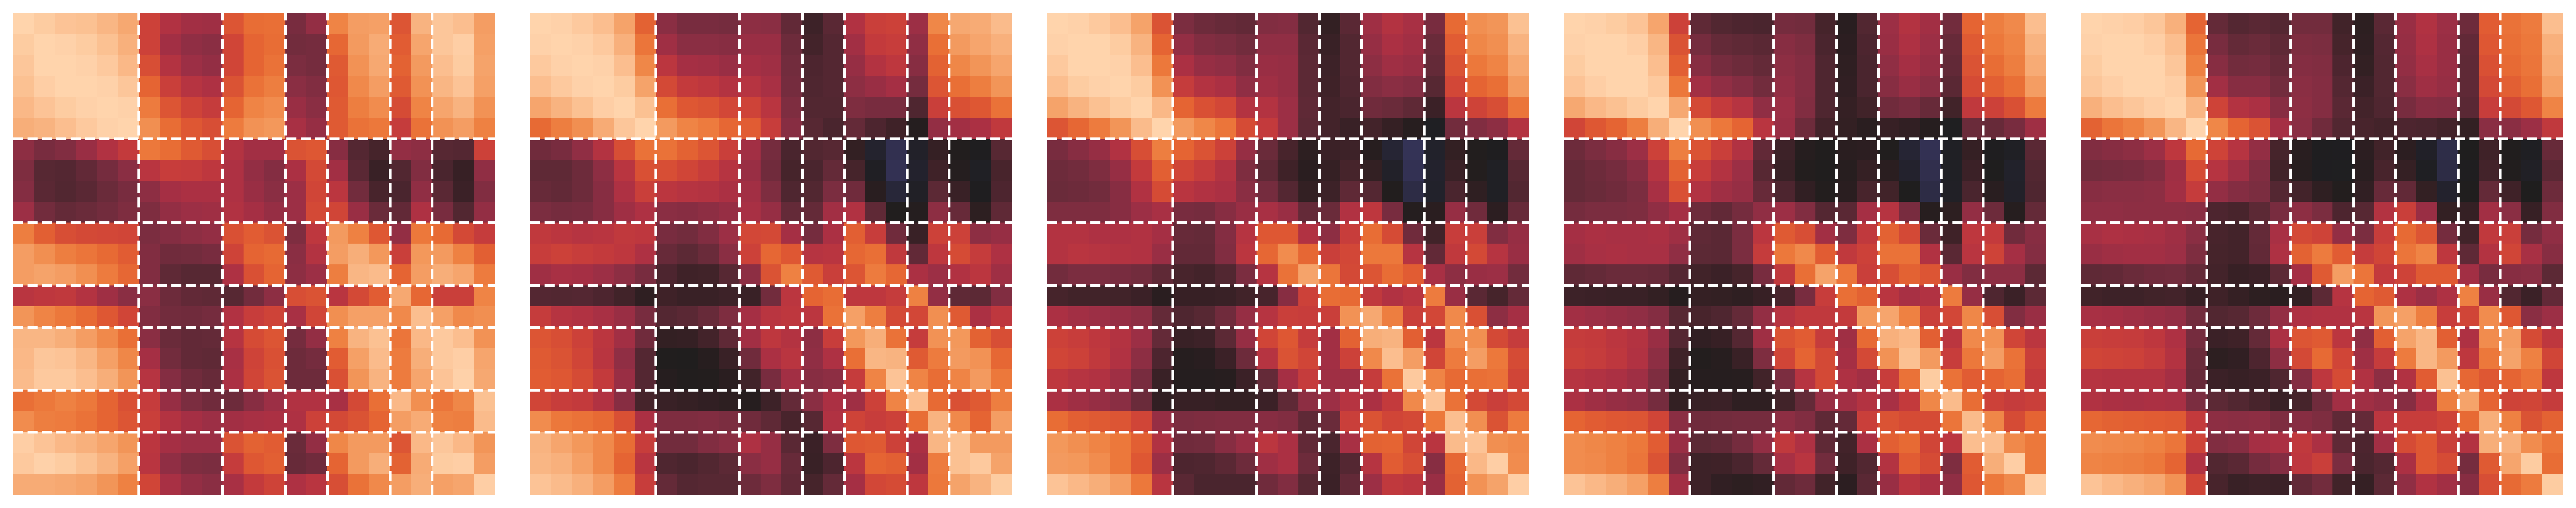

In [21]:
# calculate the average correlation matrix
#avg_corr = corr_curve.mean(axis=0)
corr_curve_single_run = corr_curve[9,:,:,:]
# select epochs
#epochs = [4, 8, 12, 16, 20]

epochs = [4, 8, 12, 16, 20]

# create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)

for i, epoch in enumerate(epochs):
    sns.heatmap(corr_curve_single_run [epoch-1], cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                cbar=False, xticklabels=False, yticklabels=False, linewidths=0)  # set linewidths to 0
    #axs[i].set_title(f'Epoch {epoch}')  # add title back
    axs[i].set_aspect('equal')  # make each subplot square
    for lines in [6, 10, 13, 15, 18, 20]:  # Removed 46 from the list
        axs[i].axvline(lines, linestyle='--', color='white', linewidth=1.5)
        axs[i].axhline(lines, linestyle='--', color='white', linewidth=1.5)


plt.tight_layout()

plt.savefig('corr_plot.pdf', format='pdf', dpi=600)

plt.show()


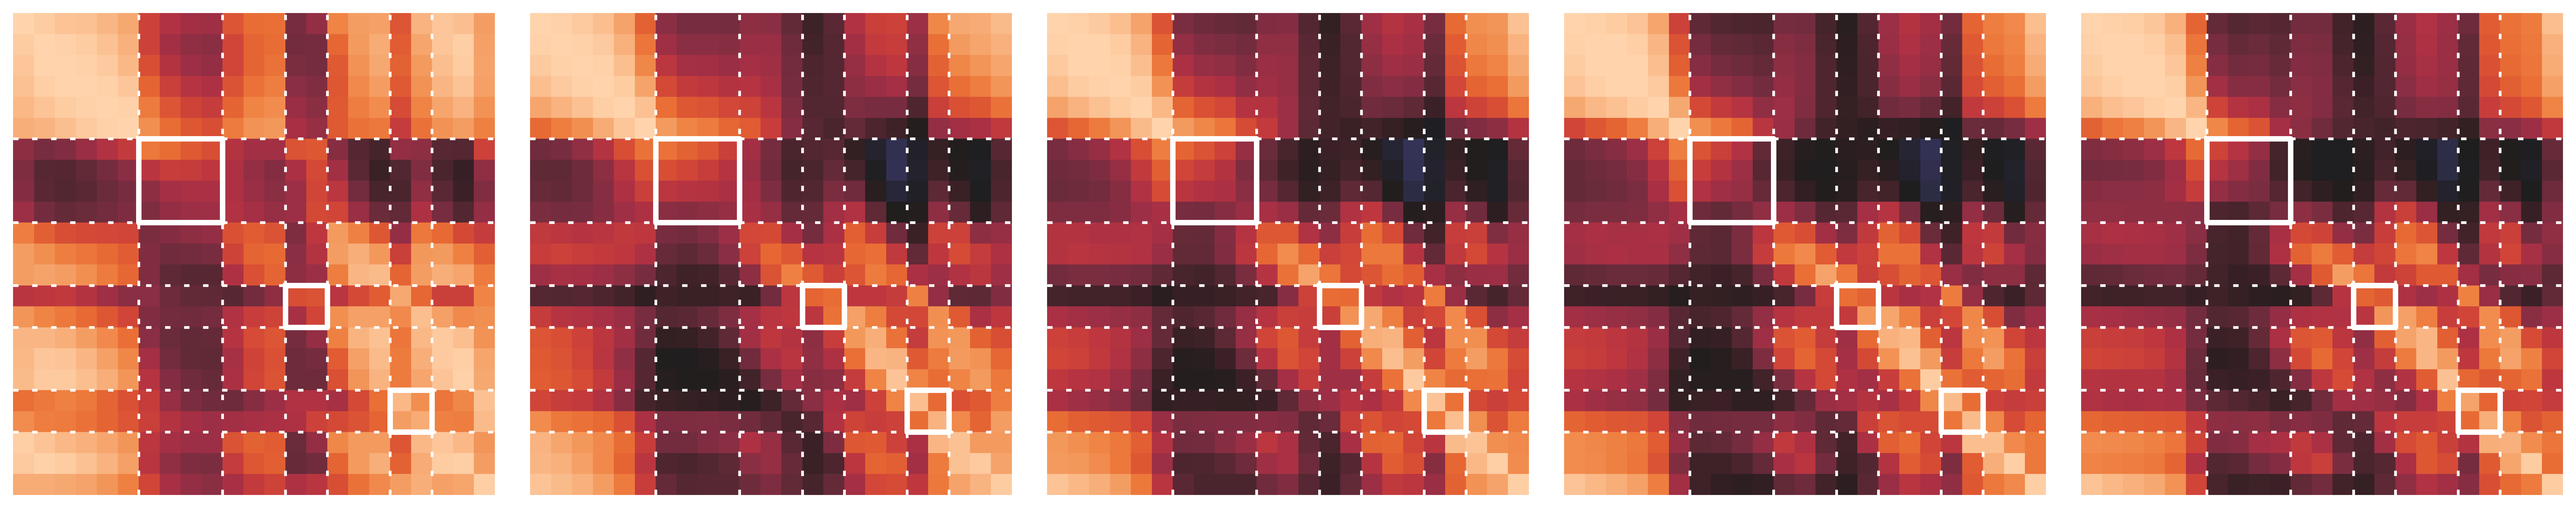

In [31]:
import datetime

epochs = [4, 8, 12, 16, 20]

# create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)

for i, epoch in enumerate(epochs):
    sns.heatmap(corr_curve_single_run [epoch-1], cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
    axs[i].set_aspect('equal')  # make each subplot square

    # Loop for dotted lines
    for lines in [6, 10, 13, 15, 18, 20]:  
        axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted vertical lines
        axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted horizontal lines

    # Draw square bounding box
    for (low, high) in [(6, 10), (13, 15), (18, 20)]:
        axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white',linewidth=3)  

plt.tight_layout()
today = datetime.datetime.now().strftime('%Y_%m_%d')  # get today's date
plt.savefig(f'corr_plot_{today}.pdf', format='pdf', dpi=600)

plt.show()




## plot activation difference

In [3]:
ind0

(array([ 0,  1,  5,  6,  7,  8, 10, 12, 14, 16, 17, 18, 19, 20, 23, 30, 31,
        33, 39, 40, 41, 42, 49, 51, 58, 60, 62, 64, 65, 66, 67, 70, 71, 72,
        73, 74, 75, 77, 78, 79, 81, 82, 84, 87, 89, 91, 94, 98]),)

In [4]:
ind1

(array([ 2,  3,  4,  9, 11, 13, 15, 21, 22, 24, 25, 26, 27, 28, 29, 32, 34,
        35, 36, 37, 38, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57,
        59, 61, 63, 68, 69, 76, 80, 83, 85, 86, 88, 90, 92, 93, 95, 96, 97,
        99]),)

In [5]:
from ipywidgets import interact
i = 1
j = 6
@interact(i_position=(0, 22))

def show_activation(i_position=0):
    plt.plot(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position]);
    plt.plot(test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position]);
    plt.show()

interactive(children=(IntSlider(value=0, description='i_position', max=22), Output()), _dom_classes=('widget-i…

In [6]:
i = ind0[0][10]
j = ind1[0][10]

@interact(i_position=(0, 22))
def show_activation(i_position=0):
    # Existing plots
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position])
    plt.plot(test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position])
    plt.title('Activation')
    
    # New plot
    plt.subplot(1, 2, 2)
    activation_diff = test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position] - test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position]
    max_activation = np.maximum(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position] ,test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position])
    ranked_activations = np.argsort(max_activation)
    
    plt.plot(max_activation[ranked_activations][::-1]
,'r-')
    plt.plot(np.abs(activation_diff[ranked_activations])[::-1]
,'g-')
    
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i_position', max=22), Output()), _dom_classes=('widget-i…

In [7]:
i = ind0[0][10]
j = ind1[0][10]
@interact(i_position=(0, 22))
def show_activation(i_position=0):
    # Existing plots
    plt.figure(figsize=(14, 6), dpi=150)
    plt.subplot(1, 2, 1)
    plt.plot(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position], label='Near')
    plt.plot(test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position], label='Far')
    plt.xlabel('Unit #', fontsize=14)  # Increase the fontsize for the x-axis label
    plt.ylabel('Activation', fontsize=14)  # Increase the fontsize for the y-axis label
    plt.legend(fontsize=12)  # Increase the fontsize for the legend
    
    # New plot
    plt.subplot(1, 2, 2)
    activation_diff = test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position] - test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position]
    max_activation = np.maximum(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position], test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position])
    ranked_activations = np.argsort(max_activation)
    
    plt.plot(max_activation[ranked_activations][::-1], 'red', label='Max Activation')
    plt.plot(np.abs(activation_diff[ranked_activations])[::-1], 'blue', label='Activation Difference')
    plt.xlabel('Unit #', fontsize=14)  # Increase the fontsize for the x-axis label
    plt.ylabel('Activation', fontsize=14)  # Increase the fontsize for the y-axis label
    plt.legend(fontsize=12)  # Increase the fontsize for the legend

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i_position', max=22), Output()), _dom_classes=('widget-i…

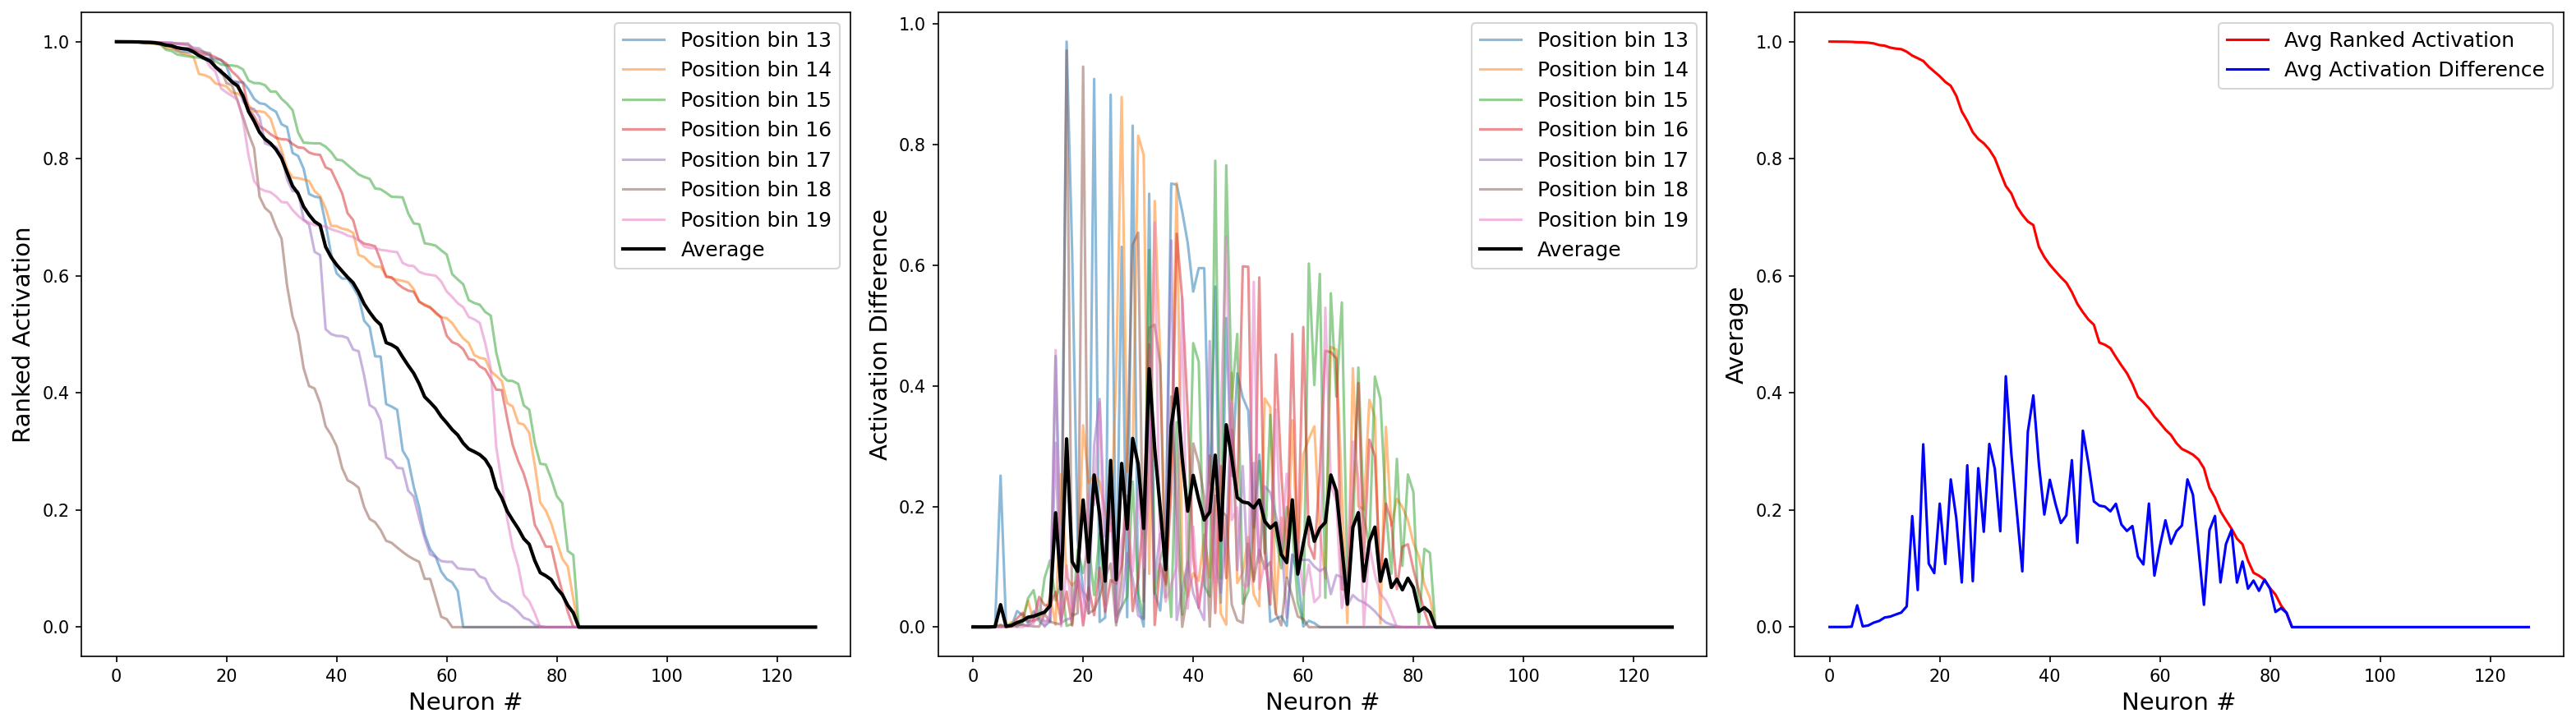

In [8]:
# Create empty lists to store averaged values
avg_ranked_activations = []
avg_activation_diffs = []

# Lists to store all activations and differences
all_ranked_activations = []
all_activation_diffs = []

all_act=[]
all_diff=[]

# Loop over specific track regions 
for i_position in range(13, 20):
    activation_diff = test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position] - test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position]
    max_activation = np.maximum(test_h[a[i]:b[i], :].squeeze().detach().numpy()[i_position], test_h[a[j]:b[j], :].squeeze().detach().numpy()[i_position])
    
    all_act.append(max_activation)
    all_diff.append(activation_diff)
    
    ranked_activations = np.argsort(max_activation)
    # Calculate and store averages
    avg_ranked_activations.append(max_activation[ranked_activations][::-1])
    avg_activation_diffs.append(np.abs(activation_diff[ranked_activations])[::-1])
    
    # Store all activations and differences
    all_ranked_activations.append(max_activation[ranked_activations][::-1])
    all_activation_diffs.append(np.abs(activation_diff[ranked_activations])[::-1])

avg_ranked_activations = np.mean(avg_ranked_activations,0)
avg_activation_diffs = np.mean(avg_activation_diffs,0)

# Plot the averaged values along with individual traces
plt.figure(figsize=(21, 6), dpi=150)

# Plot individual traces and average for Ranked Activation
plt.subplot(1, 3, 1)
for i, trace in enumerate(all_ranked_activations):
    plt.plot(trace, label=f'Position bin {i+13}', alpha=0.5)
plt.plot(avg_ranked_activations, 'black', linewidth=2, label='Average')
plt.xlabel('Neuron #', fontsize=14)
plt.ylabel('Ranked Activation', fontsize=14)
plt.legend(fontsize=12)

# Plot individual traces and average for Activation Difference
plt.subplot(1, 3, 2)
for i, trace in enumerate(all_activation_diffs):
    plt.plot(trace, label=f'Position bin {i+13}', alpha=0.5)
plt.plot(avg_activation_diffs, 'black', linewidth=2, label='Average')
plt.xlabel('Neuron #', fontsize=14)
plt.ylabel('Activation Difference', fontsize=14)
plt.legend(fontsize=12)

# Plot the average of both Ranked Activation and Activation Difference
plt.subplot(1, 3, 3)
plt.plot(avg_ranked_activations, 'red', label='Avg Ranked Activation')
plt.plot(avg_activation_diffs, 'blue', label='Avg Activation Difference')
plt.xlabel('Neuron #', fontsize=14)
plt.ylabel('Average', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


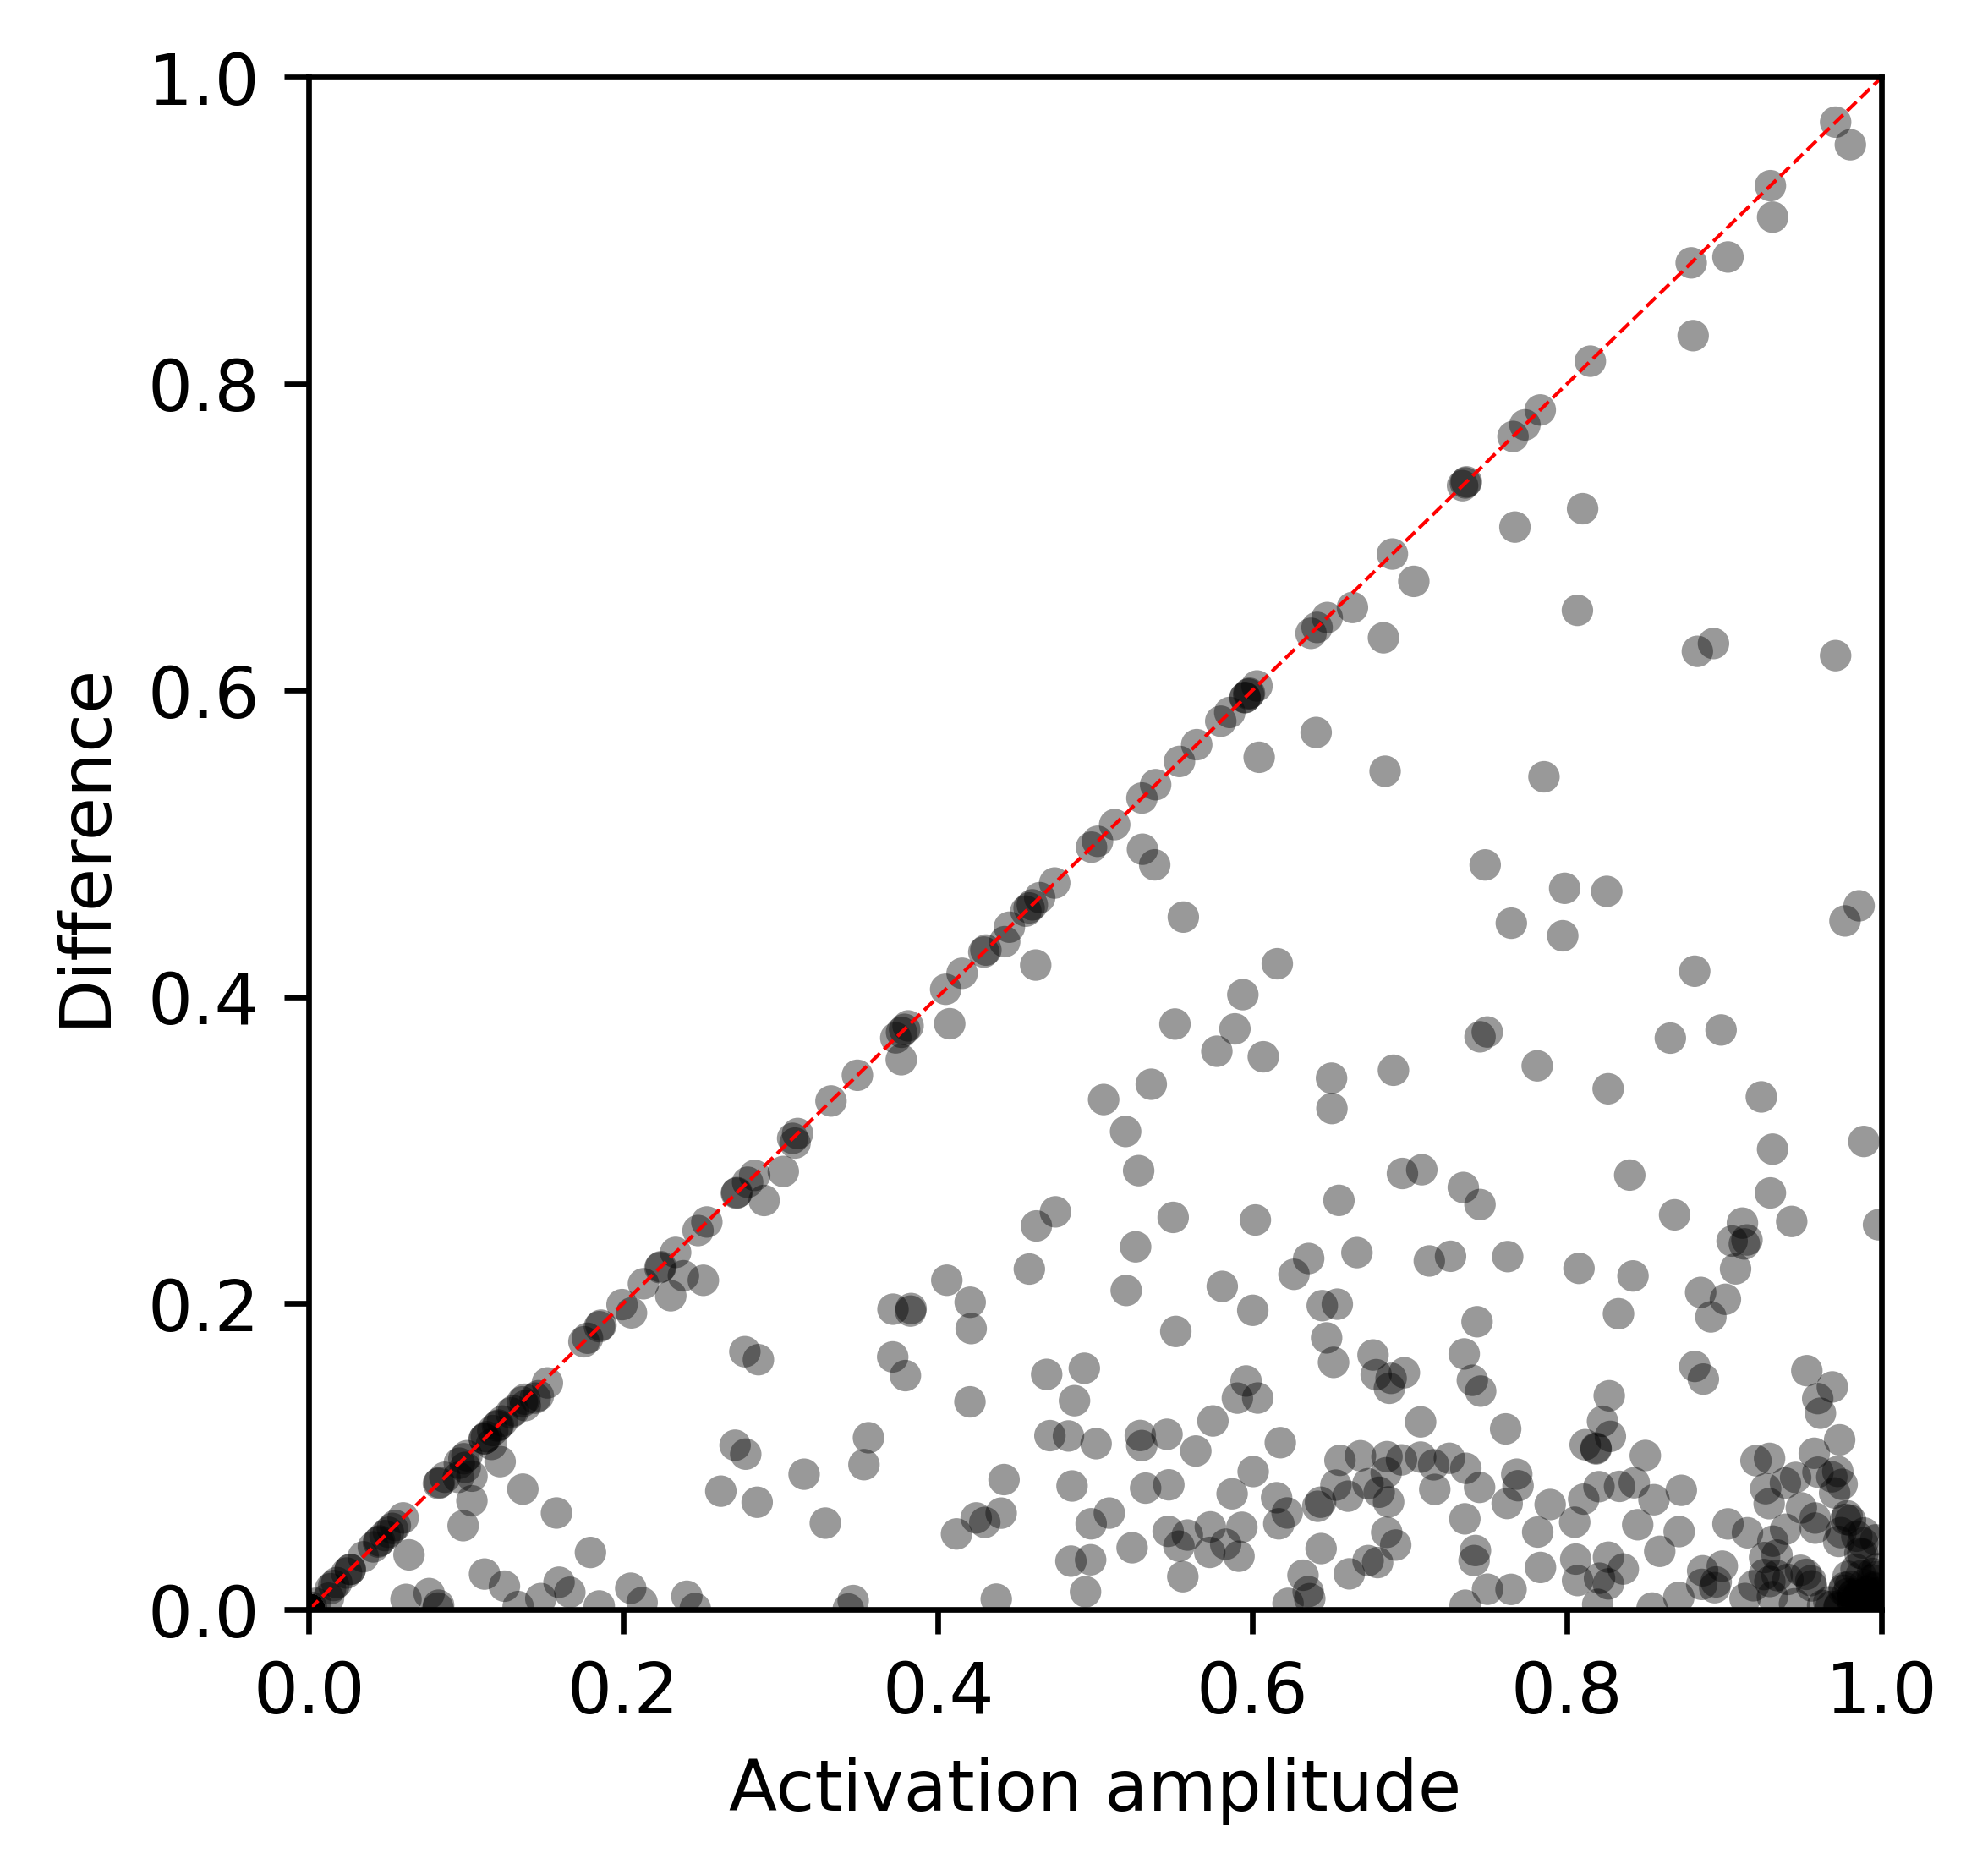

In [9]:
activation_amplitudes = avg_ranked_activations
percentage_differences = avg_activation_diffs / avg_ranked_activations

# Create figure and axes
fig, ax = plt.subplots(figsize=(4, 4), dpi=600)

# Plot the scatter points without edgecolor
ax.scatter(np.array(all_act).flatten(),np.abs(np.array(all_diff)).flatten(), color='black', marker='o', s=20, alpha=0.4, edgecolor='none')
ax.plot([0, 1], [0, 1], 'r--',linewidth = 0.5)

# Set labels and title
ax.set_xlabel('Activation amplitude')
ax.set_ylabel('Difference')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.savefig('LSTM_amplitude_vs_difference.pdf', format='pdf', dpi=600)

# Show the plot
plt.show()
